<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/Copy_of_regression_and_kalman_regression_(delta_time_series)_without_removing_outliers_and_star_with_only_emission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display
from scipy.linalg import inv
#import functions.Kalman_filter as KF

In [ ]:
data = pd.read_excel('/content/MEF-DATA.xlsx')
data.drop(data.loc[data['Date'].duplicated()].index, inplace = True)
#df['datetime'] = pd.to_datetime(df['Date'])

# df = df.sort_values(df['datetime'], ascending=[True])

data.set_index(data['Date'], inplace = True)
data.drop(columns = ['Date'], inplace = True)
data.tail()

,Generation without Renewbles,Emission,Electricity price
Date,,,
2019-12-31 18:59:59.982,39770.082481,9108.529801,41.866862
2019-12-31 19:59:59.982,37786.380986,8674.740229,40.663287
2019-12-31 20:59:59.982,37386.850362,7923.937366,40.663287
2019-12-31 21:59:59.982,34511.549048,7470.995505,40.663287
2019-12-31 22:59:59.982,31848.634781,7470.995505,38.162235


**Data cleaning**
Data can contain NaNs, negative values, zeros and outliers. Let's have a look!

In [ ]:
from pandas.core.groupby.grouper import DataFrame
data[data.isna().any(axis=1)].tail()
data=DataFrame(data)

no missing values

In [ ]:
df = data[ ["Generation without Renewbles","Emission"] ]

use delata gerneration and delta emission 

In [ ]:
#take the original time series
#ret=df
 #take first diff time series
ret = data-data.shift()[1:]
#eliminate this if not first diff time series
ret = ret[1:]
print(ret)

                         Generation without Renewbles     Emission  \
Date                                                                 
2019-01-01 00:59:59.983                  -1045.247696    19.616814   
2019-01-01 01:59:59.983                    250.171245   118.240055   
2019-01-01 02:59:59.983                  -1223.486013   306.957799   
2019-01-01 03:59:59.983                    -28.220236  1284.841991   
2019-01-01 04:59:59.983                   2019.905311  1455.265215   
...                                               ...          ...   
2019-12-31 18:59:59.982                   -544.773296  -570.296398   
2019-12-31 19:59:59.982                  -1983.701495  -433.789573   
2019-12-31 20:59:59.982                   -399.530624  -750.802862   
2019-12-31 21:59:59.982                  -2875.301315  -452.941861   
2019-12-31 22:59:59.982                  -2662.914267     0.000000   

                         Electricity price   
Date                                       

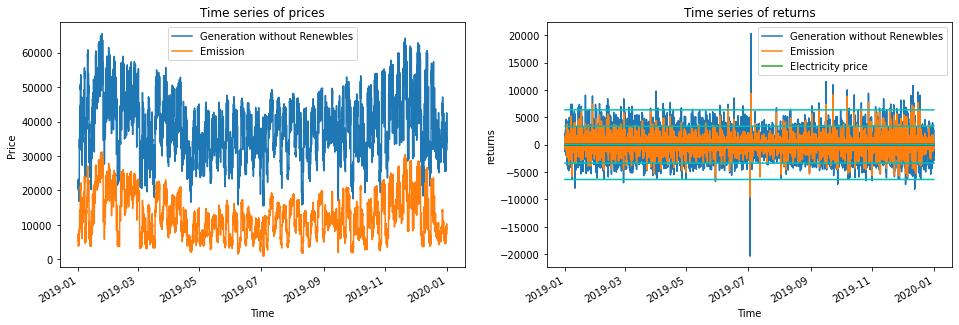

In [ ]:

NOSD = 3               # Number Of Standard Deviations
mu = ret.mean()
sig = ret.std()
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

df.plot(ax=ax1)
ax1.set_title("Time series of prices"); ax1.set_xlabel("Time"); ax1.set_ylabel("Price")
ret.plot(ax=ax2)
ax2.set_title("Time series of returns"); ax2.set_xlabel("Time"); ax2.set_ylabel("returns")
ax2.plot(ret.index, len(ret)*[mu], color="k" )
ax2.plot(ret.index, len(ret)*[mu+NOSD*sig], color='c' )
ax2.plot(ret.index, len(ret)*[mu-NOSD*sig], color='c' )
plt.show()

**What about the outliers?**


We can see that there are returns that are quite bigger than 3σ (three standard deviations).
If we assume a Normal distribution for the returns, these outliers can create problems.

Wait a second...
we calculated the standard deviation ret.std() using the data containing the ouliers!!
It means that the value of the standard deviation is aslo affected by the outliers!!

The solution is to use robust estimators of the location and the dispersion of a distribution. They work much better in presence of outliers.

Although there are several alternatives, I prefer to use the median and the MAD. These estimators are more robust than the mean and standard deviation. In the standard deviation, the distances from the mean are squared, so large deviations are weighted more heavily, and thus outliers can heavily influence it. In the MAD instead, the deviations of a small number of outliers are irrelevant.

As explained on wiki, in order to use the MAD as a consistent estimator of the standard deviation, we have to take

σ
=
k
MAD
where under the assumption of Normal distribution, 
k
=
1.4826
.



In [ ]:
median = ret.median()
MAD = ret.mad()
sig_robust = MAD*1.4826
print("STD DEV: \n", sig); print(""); print("Robust STD DEV: \n", sig_robust); 

STD DEV: 
 Generation without Renewbles    2118.565205
Emission                        1121.228741
Electricity price                  5.834078
dtype: float64

Robust STD DEV: 
 Generation without Renewbles    2229.589991
Emission                         967.464045
Electricity price                  4.672027
dtype: float64


In [ ]:
outliers = ret[ret[ np.abs(ret-median)>NOSD*sig_robust ].any(axis=1)]     # outliers
dret = ret.drop(outliers.index)                                           # series of returns without outliers

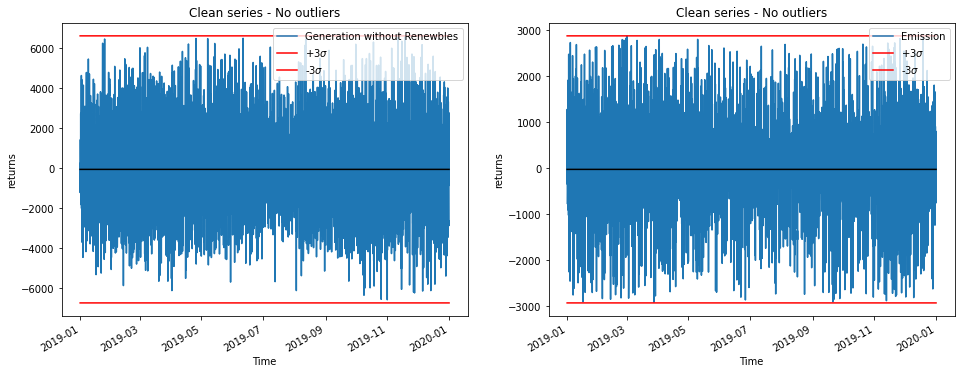

In [ ]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122) 

for ax, col in zip([ax1,ax2], dret.columns):
    dret[col].plot(ax=ax)
    ax.set_title("Clean series - No outliers"); ax.set_xlabel("Time"); ax.set_ylabel("returns")
    ax.plot(dret.index, len(dret)*[median[col]], color="k" )
    ax.plot(dret.index, len(dret)*[median[col]+NOSD*sig_robust[col]], color='r', label="+3$\sigma$" )
    ax.plot(dret.index, len(dret)*[median[col]-NOSD*sig_robust[col]], color='r', label="-3$\sigma$" )
    ax.legend(loc="upper right")
plt.show()


In [ ]:
print("We have reduced the initial DIRTY series of returns of size {} to the \
new CLEAN series of size {}.".format(len(ret),len(dret)))

We have reduced the initial DIRTY series of returns of size 8759 to the new CLEAN series of size 8158.


**Linear regression**

In [ ]:
#eliminate this if not first diff time series
#dret = dret[1:]

In [ ]:
X = dret[dret.columns[1]]
Y = dret[dret.columns[0]]
print("In our regression Y is {} and X is {}".format(dret.columns[0],dret.columns[1]) )

In our regression Y is Generation without Renewbles and X is Emission


In [ ]:
print(Y)

Date
2019-01-01 00:59:59.983   -1045.247696
2019-01-01 01:59:59.983     250.171245
2019-01-01 02:59:59.983   -1223.486013
2019-01-01 03:59:59.983     -28.220236
2019-01-01 05:59:59.983    -675.766189
                              ...     
2019-12-31 18:59:59.982    -544.773296
2019-12-31 19:59:59.982   -1983.701495
2019-12-31 20:59:59.982    -399.530624
2019-12-31 21:59:59.982   -2875.301315
2019-12-31 22:59:59.982   -2662.914267
Name: Generation without Renewbles, Length: 8158, dtype: float64


In [ ]:
b_ss, a_ss, r_ss, _, std_err_ss = ss.linregress(X,Y)
print("We can use one of the many python functions:\nbeta: {0:6f}, alpha: {1:6f}, R2: {2:6f}, \
standard error: {3:6f}.".format(b_ss, a_ss, r_ss**2, std_err_ss))

beta_tot_OLS = np.cov(X,Y,ddof=1)[0,1] / np.var(X,ddof=1)
alpha_tot_OLS = np.mean(Y) - beta_tot_OLS * np.mean(X)
res = Y - beta_tot_OLS * X - alpha_tot_OLS
std_eps_OLS = np.std(res, ddof=2) 
print("\nOr I can estimate by myself:\nbeta: {}, alpha: {}, sigma: {}".format(beta_tot_OLS, 
                                                                             alpha_tot_OLS, std_eps_OLS))

We can use one of the many python functions:
beta: 1.418395, alpha: -16.821483, R2: 0.359745, standard error: 0.020953.

Or I can estimate by myself:
beta: 1.4183949530422149, alpha: -16.82148307818779, sigma: 1518.8278163803302


In [ ]:
n = len(X)
x_mean = np.mean(X); y_mean = np.mean(Y)
Sxx = (X-x_mean) @ (X-x_mean)
Syy = (Y-y_mean) @ (Y-y_mean)
Sxy = (X-x_mean) @ (Y-y_mean)
beta_hat = Sxy/Sxx; alpha_hat = y_mean - beta_hat * x_mean    # beta and alpha
print("beta: {} and alpha: {}".format(beta_hat,alpha_hat))
epsilon = Y - beta_hat * X - alpha_hat             # residuals
S2 = epsilon @ epsilon / (n-2); S = np.sqrt(S2)    # unbiased estimator
print("sigma: {}".format(S))
var_beta = S2/Sxx                 # variance of beta 
var_alpha = (X@X) * S2/(Sxx * n)  # variance of alpha 
s_b = np.sqrt(var_beta)           # standard error for beta
s_a = np.sqrt(var_alpha)          # standard error for alpha
R2 = Sxy**2 / (Sxx*Syy)           
print("Standard Error for beta: ", s_b); print("R squared: {}".format(R2))
CI_b = ss.t.interval(0.95, n-2, loc=beta_hat, scale=s_b );  b_up = CI_b[0]; b_down = CI_b[1]
CI_a = ss.t.interval(0.95, n-2, loc=alpha_hat, scale=s_a )
print("Confidence intervals for beta: ", CI_b); print("Confidence intervals for alpha: ", CI_a)

beta: 1.4183949530422137 and alpha: -16.821483078187825
sigma: 1518.8278163803307
Standard Error for beta:  0.020952601044632424
R squared: 0.35974471478384235
Confidence intervals for beta:  (1.3773225144057744, 1.4594673916786531)
Confidence intervals for alpha:  (-49.8080723708433, 16.16510621446765)


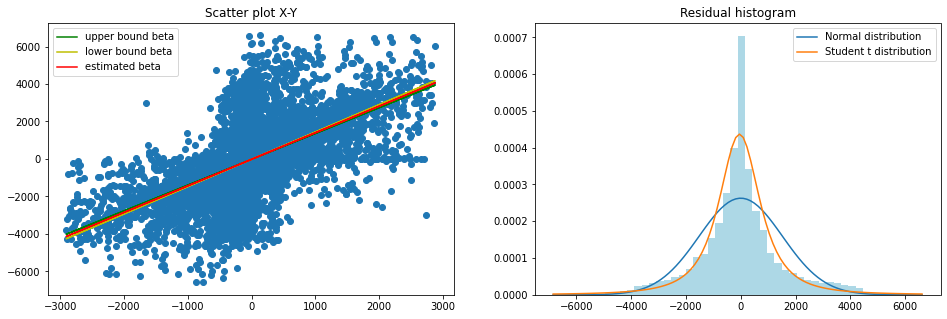

In [ ]:
x = np.linspace(res.min(),res.max(),100)     # res are the residuals

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.scatter(X, Y); ax1.set_title("Scatter plot X-Y") 
ax1.plot(X, alpha_hat + b_up*X, color="g", label="upper bound beta")
ax1.plot(X, alpha_hat + b_down*X, color="y", label="lower bound beta")
ax1.plot(X, alpha_hat + beta_hat*X, color="red", label="estimated beta"); ax1.legend(loc="upper left")
ax2.plot(x, ss.norm.pdf(x,0,S), label="Normal distribution")
params = ss.t.fit(res)
ax2.plot(x, ss.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax2.hist(res, bins=50, density=True, facecolor="LightBlue") 
ax2.legend(); ax2.set_title("Residual histogram"); plt.show()

In [ ]:
print("Degrees of freedom of fitted t distribution: ", params[0])

Degrees of freedom of fitted t distribution:  1.9691933064284464


**The Kalman filter**

In [ ]:
Y = dret.columns[0]
X = dret.columns[1]

In [ ]:
print(Y)

Generation without Renewbles


In [ ]:
training_size = 8000
ret_train = dret.iloc[:training_size] 

In [ ]:
beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(ret_train[X], ret_train[Y])
resid_tr = ret_train[Y] - beta_tr * ret_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)                       # a possible initial guess for var_eps
print("In the training set the OLS estimators of") 
print("alpha_tr = ", alpha_tr); print("beta_tr = ", beta_tr); print("var_eps = ", var_eps_ols) 

In the training set the OLS estimators of
alpha_tr =  -17.43358237193052
beta_tr =  1.4210485840896683
var_eps =  2309331.6072705206


In [ ]:
total_length = len(dret)
training_size = total_length - 8134

ret_test = dret.iloc[training_size:]

In [ ]:
training_size

24

In [ ]:
print(ret_train)

                         Generation without Renewbles     Emission  \
Date                                                                 
2019-01-01 00:59:59.983                  -1045.247696    19.616814   
2019-01-01 01:59:59.983                    250.171245   118.240055   
2019-01-01 02:59:59.983                  -1223.486013   306.957799   
2019-01-01 03:59:59.983                    -28.220236  1284.841991   
2019-01-01 05:59:59.983                   -675.766189  -343.989287   
...                                               ...          ...   
2019-12-24 22:59:59.982                   -250.555754  -507.327501   
2019-12-24 23:59:59.982                  -1586.521862    17.686028   
2019-12-25 00:59:59.982                     26.031613    78.208965   
2019-12-25 01:59:59.982                    119.552585   209.939011   
2019-12-25 02:59:59.982                    311.338957   734.182936   

                         Electricity price   
Date                                       

**Rolling alpha and beta**

Here I calculate the OLS α and  β  in the test set, using a rolling window.

In [ ]:
rolling_window = 24
rolling_beta = []
rolling_std_err = []
rolling_alpha = []

for i in range( len(ret_test) ):
    ret_temp = df.iloc[ 1+i+training_size-rolling_window : 1+i+training_size ]
    beta_temp, alpha_temp , _ ,_ , std_err_temp  = ss.linregress(ret_temp[X],ret_temp[Y])
    rolling_beta.append(beta_temp)
    rolling_std_err.append(std_err_temp)
    rolling_alpha.append(alpha_temp)
ret_test = ret_test.assign(ols_beta=np.array(rolling_beta))
ret_test = ret_test.assign(ols_std_err=np.array(rolling_std_err))
ret_test = ret_test.assign(ols_alpha=np.array(rolling_alpha))

**Implementation of the Kalman filter for α and beta**

initial values estimating

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# your time series data
data = dret
endog=data["Generation without Renewbles"].values.reshape(1,-1)
exog=data["Emission"].values.reshape(1,-1)

# fit a simple linear regression model
reg = LinearRegression().fit(endog, exog)

# calculate the residuals from the linear regression model
residuals = endog - reg.predict(endog)

# estimate the initial variance of the residuals
var_eps_ols = np.var(residuals)

# estimate the initial covariance matrix of alpha and beta
P = np.cov(residuals, reg.predict(endog))[0,1]
P = np.array([[var_eps_ols, P], [P, var_eps_ols]])

# estimate the variances of the process noise
eta_alpha = np.var(residuals) / len(residuals)
eta_beta = np.var(reg.predict(endog)) / len(residuals)
Q = np.diag([eta_alpha, eta_beta])

# initialize the other variables for the Kalman filter
x = np.array([[reg.intercept_],[reg.coef_[0]]])        # initial mean of alpha and beta
R = np.array([[var_eps_ols]])               # variance for the measurement - 1 dim 
F = np.eye(2)                               # transition matrix
#H = np.vstack( (np.ones(len(data)), data[:,0]) ).T                 # measurement matrix
print(eta_alpha)
print(eta_beta)
print(P)


2419025.983708209
644106.2247907702
[[2419025.98370821  269523.83165441]
 [ 269523.83165441 2419025.98370821]]


In [ ]:
x = np.array([[alpha_tr],[beta_tr]])        # initial mean of alpha and beta
P = 15641257.3 * np.eye(2)                         # initial covariance of alpha and beta
eta_alpha = 2419025.98                     # variance of the alpha process 
eta_beta = 269523.83                          # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])          # process covariance matrix 
R = np.array([[var_eps_ols]])               # variance for the measurement - 1 dim 
F = np.eye(2)                               # transition matrix
H = np.vstack( (np.ones(len(ret_test)), ret_test[X].values) ).T                 # measurement matrix

In [ ]:
alphas, betas = np.full( len(ret_test), np.NaN ), np.full( len(ret_test), np.NaN )
for i,y in enumerate(ret_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q
    
    #update
    S = (H[None,i] @ P @ H[None,i].T) + R     # Here S is a scalar
    K = (P @ H[None,i].T) @ inv(S)             
    r = y - H[None,i]@x                       # residuals
    x = x + K @ r                             # v is a scalar. 
    P = P - K @ H[None,i] @ P                 # K @ H[None,i] is an outer product
    
    alphas[i] = x[0]; betas[i] = x[1]

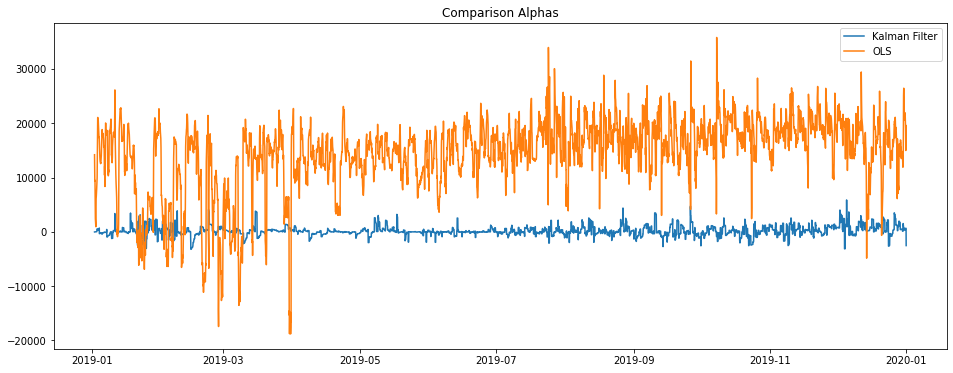

In [ ]:
plt.figure(figsize=(16,6))
plt.plot( ret_test.index, alphas, label="Kalman Filter")
plt.plot( ret_test["ols_alpha"], label="OLS" )
plt.legend(); plt.title("Comparison Alphas"); plt.show()

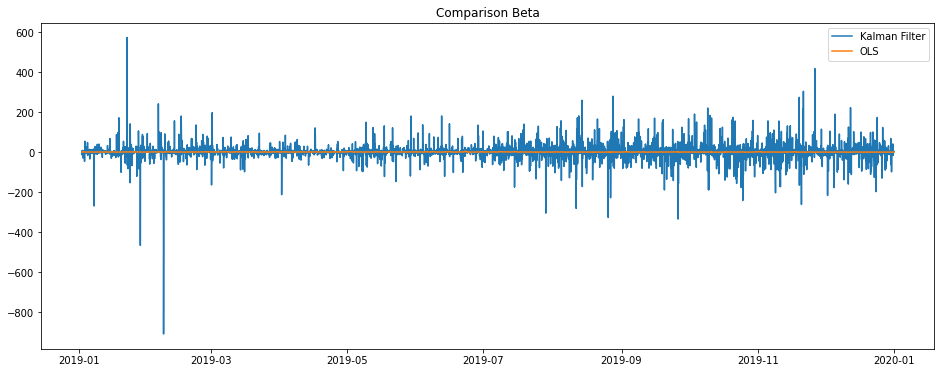

In [ ]:
plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter")
plt.plot( ret_test["ols_beta"], label="OLS" )
plt.legend(); plt.title("Comparison Beta"); plt.show()

In [ ]:
ret_test["ols_beta"]

Date
2019-01-02 04:59:59.983    1.197233
2019-01-02 05:59:59.983    1.483412
2019-01-02 06:59:59.983    1.778614
2019-01-02 07:59:59.983    1.946097
2019-01-02 08:59:59.983    1.936275
                             ...   
2019-12-31 18:59:59.982    1.945882
2019-12-31 19:59:59.982    1.891295
2019-12-31 20:59:59.982    1.691099
2019-12-31 21:59:59.982    1.612840
2019-12-31 22:59:59.982    1.552817
Name: ols_beta, Length: 8134, dtype: float64

In [ ]:
import pandas as pd

beta_kalman = pd.Series(betas, index=ret_test.index)
print(beta_kalman)

Date
2019-01-02 04:59:59.983     1.855921
2019-01-02 05:59:59.983   -12.876848
2019-01-02 06:59:59.983     9.806817
2019-01-02 07:59:59.983     3.023542
2019-01-02 08:59:59.983     3.016459
                             ...    
2019-12-31 18:59:59.982     2.107003
2019-12-31 19:59:59.982     6.085966
2019-12-31 20:59:59.982     1.405454
2019-12-31 21:59:59.982     7.792625
2019-12-31 22:59:59.982     1.069529
Length: 8134, dtype: float64


In [ ]:
mean=np.mean(beta_kalman)
mean

2.6908556932460095

In [ ]:
beta_ols=ret_test["ols_beta"]
print(beta_ols)

Date
2019-01-02 04:59:59.983    1.197233
2019-01-02 05:59:59.983    1.483412
2019-01-02 06:59:59.983    1.778614
2019-01-02 07:59:59.983    1.946097
2019-01-02 08:59:59.983    1.936275
                             ...   
2019-12-31 18:59:59.982    1.945882
2019-12-31 19:59:59.982    1.891295
2019-12-31 20:59:59.982    1.691099
2019-12-31 21:59:59.982    1.612840
2019-12-31 22:59:59.982    1.552817
Name: ols_beta, Length: 8134, dtype: float64


In [ ]:
meanols=np.mean(beta_ols)
meanols

1.8562499572373878

Calculate R2 for each regression

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Define the input data (x) and the actual output data (y)
x = np.array(ret_test[X])
y = np.array(ret_test[Y])
beta_ols=np.array(beta_ols)
beta_kalman=np.array(beta_kalman)

# Calculate the predictions for each regression
y_pred_ols = beta_ols * x
y_pred_kalman = beta_kalman * x

# Calculate the R^2 for each regression
r2_simple = r2_score(y, y_pred_ols)
r2_kalman = r2_score(y, y_pred_kalman)

# Print the R^2 values
print("R^2 for simple regression:", r2_simple)
print("R^2 for Kalman filter regression:", r2_kalman)


R^2 for simple regression: 0.3022550007451422
R^2 for Kalman filter regression: 0.7601291717062878


In [ ]:
# Calculate the MSE
mse_ols = np.mean((y - y_pred_ols) ** 2)
mse_kalman = np.mean((y - y_pred_kalman) ** 2)
# Print the MSE
print("MSE for simple regression:", mse_ols)
print("MSE for Kalman filter regression:", mse_kalman)

MSE for simple regression: 2517741.2207250446
MSE for Kalman filter regression: 865549.2661208549


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the actual data (y) and the predictions (y_pred)

# Plot the actual data and predictions
plt.plot(y, label='Actual')
#plt.plot(y_pred_ols, label='Prediction with ols')
plt.plot(y_pred_kalman, label='Prediction with kalman')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


ValueError: ignored

**LSTAR MODEL**

In [ ]:
import numpy as np
from joblib import Parallel, delayed
from scipy.optimize import least_squares

def transition_function(s_t, gamma, c):
    return 1 / (1 + np.exp(-gamma * (s_t - c)))

def STR(x, phi0, phi1, phi2, theta0, theta1, theta2, gamma, c):
    x_t = x[:, 0]
    s_t = x[:, 1]
    G = transition_function(s_t, gamma, c)
    y_hat = phi0 + phi1 * x_t + phi2 * s_t + (theta0 + theta1 * x_t + theta2 * s_t) * G
    return y_hat

# y is a 1D array containing the values of y
y = dret['Generation without Renewbles']
x = dret[['Emission', 'Electricity price ']].to_numpy()

# specify the window size
window_size = 24

# generate indices for the rolling window
indices = [(i-window_size, i) for i in range(window_size, len(y))]

# initial guesses for the parameters
phi0_0, phi1_0, phi2_0 = -237.00540, 0.5416, 447.98395
theta0_0, theta1_0, theta2_0 = 601.20749, 0.91319, -422.49485
gamma_0, c_0 = 0.50000, -6.41804
p0 = np.array([phi0_0, phi1_0, phi2_0, theta0_0, theta1_0, theta2_0, gamma_0, c_0])
bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0, -np.inf],
          [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

# estimate the parameters using nonlinear least squares for each rolling window in parallel
n_jobs = -1  # use all available cores
results = Parallel(n_jobs=n_jobs)(
    delayed(least_squares)(lambda p: STR(x[i:j], *p) - y[i:j], p0, method='trf', bounds=bounds)
    for i, j in indices
)
coefficients = np.array([res.x for res in results])

# extract the time-varying coefficients
phi0_t = coefficients[:, 0]
phi1_t = coefficients[:, 1]
phi2_t = coefficients[:, 2]
theta0_t = coefficients[:, 3]
theta1_t = coefficients[:, 4]
theta2_t = coefficients[:, 5]
gamma_t = coefficients[:, 6]
c_t = coefficients[:, 7]

In [ ]:
# create a DataFrame containing the coefficients and the time series of the transition function
data = pd.DataFrame({
    'phi0_t': phi0_t,
    'phi1_t': phi1_t,
    'phi2_t': phi2_t,
    'theta0_t': theta0_t,
    'theta1_t': theta1_t,
    'theta2_t': theta2_t,
    'gamma_t': gamma_t,
    'c_t': c_t,
})

# save the DataFrame to an Excel file
data.to_excel('coefficients.xlsx', index=False)

In [ ]:
import matplotlib.pyplot as plt

# plot phi0_t
plt.plot(phi0_t)
plt.xlabel('Time')
plt.ylabel('phi0_t')
plt.show()

# plot phi1_t
plt.plot(phi1_t)
plt.xlabel('Time')
plt.ylabel('phi1_t')
plt.show()

# plot phi2_t
plt.plot(phi2_t)
plt.xlabel('Time')
plt.ylabel('phi2_t')
plt.show()

# plot theta0_t
plt.plot(theta0_t)
plt.xlabel('Time')
plt.ylabel('theta0_t')
plt.show()

# plot theta1_t
plt.plot(theta1_t)
plt.xlabel('Time')
plt.ylabel('theta1_t')
plt.show()

# plot theta2_t
plt.plot(theta2_t)
plt.xlabel('Time')
plt.ylabel('theta2_t')
plt.show()

# plot gamma_t
plt.plot(gamma_t)
plt.xlabel('Time')
plt.ylabel('gamma_t')
plt.show()

# plot c_t
plt.plot(c_t)
plt.xlabel('Time')
plt.ylabel('c_t')
plt.show()

# plot the time series of the transition function
#plt.plot(transition_function(x[:, 1], gamma_t, c_t))
#plt.xlabel('Time')
#plt.ylabel('Transition function')
#plt.show()

In [ ]:
import numpy as np

# assume that phi0_t, phi1_t, phi2_t, theta0_t, theta1_t, theta2_t, gamma_t, c_t are arrays of shape (N,)
avg_phi0 = np.mean(phi0_t)
avg_phi1 = np.mean(phi1_t)
avg_phi2 = np.mean(phi2_t)
avg_theta0 = np.mean(theta0_t)
avg_theta1 = np.mean(theta1_t)
avg_theta2 = np.mean(theta2_t)
avg_gamma = np.mean(gamma_t)
avg_c = np.mean(c_t)

# print the averages
print("Average phi0:", avg_phi0)
print("Average phi1:", avg_phi1)
print("Average phi2:", avg_phi2)
print("Average theta0:", avg_theta0)
print("Average theta1:", avg_theta1)
print("Average theta2:", avg_theta2)
print("Average gamma:", avg_gamma)
print("Average c:", avg_c)

Average phi0: -48555.43711231495
Average phi1: -58.3771601697057
Average phi2: -2697.118801317898
Average theta0: 1054801.6571251315
Average theta1: 537.1142769754706
Average theta2: -129605.82495671137
Average gamma: 31.77064992972649
Average c: -9.956158510066995


In [ ]:
# calculate the predicted values of y
y_pred = STR(x[24:], phi0_t, phi1_t, phi2_t, theta0_t, theta1_t, theta2_t, gamma_t, c_t)
# calculate the mean of y
y_mean = np.mean(y[24:])

# calculate the sum of squared errors
SSE = np.sum((y[24:] - y_pred)**2)

# calculate the total sum of squares
SST = np.sum((y[24:] - y_mean)**2)

# calculate the R-squared
R2 = 1 - SSE/SST

print("R-squared:", R2)

R-squared: 0.6751031744100513


<ipython-input-47-7e8d620249c1>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-gamma * (s_t - c)))


In [ ]:
# predict the values using the model
y_pred = STR(x[24:], *coefficients[-1])

# calculate the evaluation metrics
mae = np.mean(np.abs(y[24:] - y_pred))
mse = np.mean((y[24:] - y_pred)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y[24:] - y_pred)/y[24:])) * 100

# calculate Theil's U-statistic
naive = np.roll(y[24:], -1)
u_stat = np.sqrt(np.mean((y[24:] - y_pred)**2)/np.mean((y[24:] - naive)**2))

# print the results
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE:', mape)
print("Theil's U-statistic:", u_stat)

MAE: 988.8556723438837
MSE: 1978669.235506937
RMSE: 1406.6517818944876
MAPE: inf
Theil's U-statistic: 0.7118181827332872


In [ ]:
sse = np.sum((y[24:] - y_pred)**2)
## compute the number of parameters
k = len(coefficients.T)

# compute the number of observations
n = len(y[24:])

# compute the BIC and AIC
bic = n * np.log(sse/n) + k * np.log(n)
aic = n * np.log(sse/n) + 2 * k

print("BIC:", bic)
print("AIC:", aic)

BIC: 117998.23435196104
AIC: 117942.20388726931


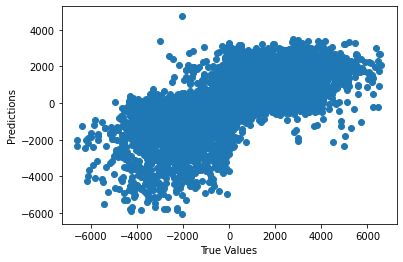

In [ ]:
import matplotlib.pyplot as plt

# plot y_pred vs y
plt.scatter(y[24:], y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


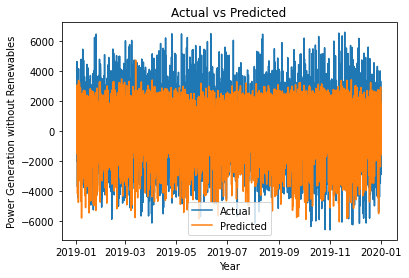

In [ ]:
import matplotlib.pyplot as plt

# plot the time series of y and y_pred
plt.plot(dret.index[window_size:], y[24:], label='Actual')
plt.plot(dret.index[window_size:], y_pred, label='Predicted')

# set the title and axis labels
plt.title('Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('Power Generation without Renewables')

# display the legend
plt.legend()

# show the plot
plt.show()


In [ ]:
import pandas as pd

# Create a DataFrame for y and y_pred
results = pd.DataFrame({
    'y': y[24:],
    'y_pred': y_pred
})

# Save to an Excel file
results.to_excel('results.xlsx', index=False)

# Create a DataFrame for the coefficients
coefficients_df = pd.DataFrame({
    'phi0_t': phi0_t,
    'phi1_t': phi1_t,
    'phi2_t': phi2_t,
    'theta0_t': theta0_t,
    'theta1_t': theta1_t,
    'theta2_t': theta2_t,
    'gamma_t': gamma_t,
    'c_t': c_t
})

# Save to an Excel file
coefficients_df.to_excel('coefficients.xlsx', index=False)

# Create a DataFrame for the transition function
s_t = np.arange(-10, 10, 0.1) # set the range of s_t values to plot
G = transition_function(s_t, gamma_t[-1], c_t[-1]) # use the final gamma and c values from the model
transition_df = pd.DataFrame({
    's_t': s_t,
    'G': G
})

# Save to an Excel file
transition_df.to_excel('transition_function.xlsx', index=False)